# 1. 에일리언 vs 프레데터 데이터 셋
  * https://www.kaggle.com/datasets/pmigdal/alien-vs-predator-images
  * Kaggle 로그인 → 계정 클릭 → Your Profile → Account → API 항목에 Create New API Token을 클릭하여 json 파일을 다운로드
  * {"username":"wooseok1004","key":"712fb964562ed4406107ee277db64263"}

In [8]:
import os

In [12]:
os.environ['KAGGLE_USERNAME'] = 'wooseok1004'   # username
os.environ['KAGGLE_KEY']  = '712fb964562ed4406107ee277db64263'  # key

In [13]:
!kaggle datasets download -d pmigdal/alien-vs-predator-images
!unzip -q alien-vs-predator-images.zip

  0% 0.00/14.1M [00:00<?, ?B/s]
100% 14.1M/14.1M [00:00<00:00, 171MB/s]


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# 2. 이미지 증강 기법(Image Augmentation)
  * 원본 이미지(데이터)를 조작하여 원본과는 크고 작은 변화를 가진 이미지를 생성
    * 일반적으로 모델 성능이 좋아짐
    * Over fitting 방지
  * https://pytorch.org/vision/master/transforms.html

In [16]:
data_transforms = {
    'train' : transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),     # 함수를 10가지 랜덤하게 생성
        transforms.RandomHorizontalFlip(),  # 이미지를 뒤집기
        transforms.ToTensor()
    ]),
    'validation' : transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

In [17]:
def target_transforms(target):
    return torch.FloatTensor([target])

In [20]:
, dataloader
image_datasets = {
    'train': datasets.ImageFolder('data/train', data_transforms['train'], target_transform=target_transforms),
    'validation': datasets.ImageFolder('data/validation', data_transforms['validation'], target_transform=target_transforms)
}

dataloaders = {
    'train': DataLoader(
        image_datasets['train'],
        batch_size=32,
        shuffle=True
    ),
    'validation': DataLoader(
        image_datasets['validation'],
        batch_size=32,
        shuffle=False
    )
}

print(len(image_datasets['train']), len(image_datasets['validation']))

694 200


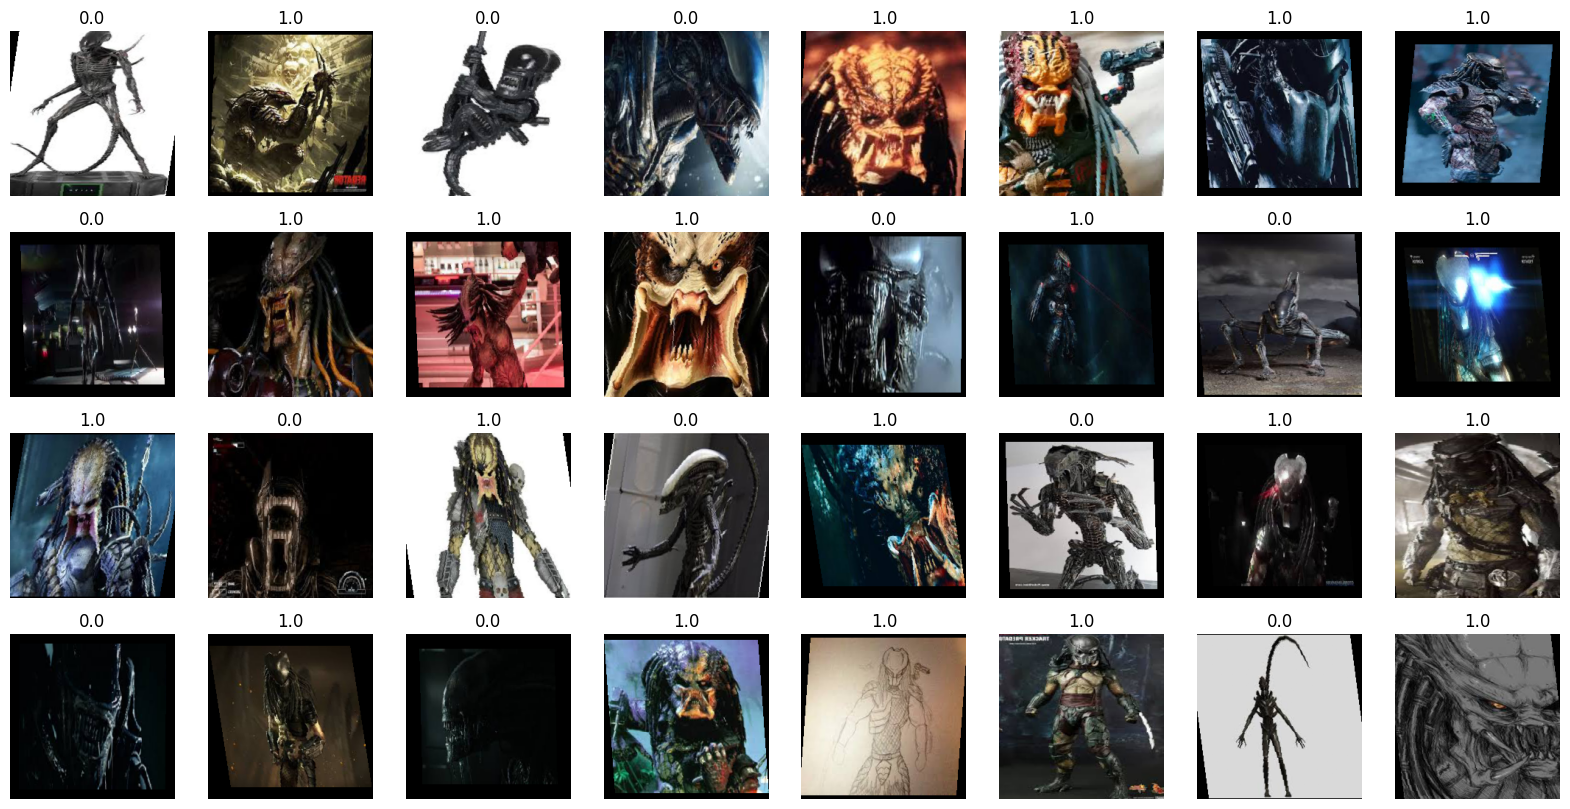

In [22]:
imgs, lavels = next(iter(dataloaders['train']))

fig, axes = plt.subplots(4, 8, figsize=(20, 10))

for img, label, ax in zip(imgs, lavels, axes.flatten()):
    ax.set_title(label.item())
    ax.imshow(img.permute(1, 2, 0))
    ax.axis('off')

# 3. 전이학습(Transfer Learning)
  * 하나의 작업을 위해 학습된 모델을 유사 작업 모델의 시작점으로 활용하는 딥러닝 접근법
  * 신경망은 처음부터 새로 학습하는 것보다 전이 학습을 통해 업데이트하고, 재학습하는 편이 더 빠르고 간편함
  * 전이학습은 검출, 검색, 영상인식, 음성인식에 많이 사용
    ![](https://miro.medium.com/max/1400/1*9GTEzcO8KxxrfutmtsPs3Q.png)
----------------------------------
* 전이학습의 고려할 점
    * 크기 : 모델 크기는 모델을 배포할 위치와 방법에 따라 달라짐
    * 정확도 : 모델 성능이 어느 정도인지 확인 필요
    * 예측속도 : 모델의 아키텍쳐와 모델 크기에 따라서도 달라짐
    ![](https://kr.mathworks.com/discovery/transfer-learning/_jcr_content/mainParsys/image.adapt.full.medium.jpg/1634621302937.jpg)

# 4. 사전 학습된 ResNet-50 모델
  * [파이토치에서 제공하는 사전학습 모델들](https://pytorch.org/vision/stable/models.html)
  ![](https://i.stack.imgur.com/gI4zT.png)

### 4-1. 이미지넷(ImageNet)
  * 이미지 데이터베이스
  * 1000개의 동물과 사물 이미지를 포함
![](https://i.imgur.com/5Rz5s8e.png)

In [23]:
# model = model = models.resnet50(pretrained=True).to(device)
model = models.resnet50(weights = 'IMAGENET1K_V1').to(device)
print(model)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 139MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### 4-2. Freeze Layers
  * 특징을 뽑아내는 CNN의 앞쪽 컨볼루션 레이어들은 학습을 하지 않도록 설정
  * 출력 부분의 레이어(FC)를 다시 설정하여 분류에 맞게 설정

In [24]:
for param in model.parameters():
    param.requires_grad = False     # 가져온 파라미터(W, b)를 업데이트하지 않음

model.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid()
).to(device)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [25]:
# 학습 : fc 부분만 학습하므로 속도가 빠름
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

epochs = 10

for epoch in range(epochs):
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        sum_losses = 0
        sum_accs = 0

        for x_batch, y_batch in dataloaders[phase]:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred = model(x_batch)

            loss = nn.BCELoss()(y_pred, y_batch)

            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            sum_losses = sum_losses + loss.item()

            y_bool = (y_pred >= 0.5).float()
            acc = (y_batch == y_bool).float().sum() / len(y_batch) * 100
            sum_accs = sum_accs + acc.item()

        avg_loss = sum_losses / len(dataloaders[phase])
        avg_acc = sum_accs / len(dataloaders[phase])

        print(f'{phase:10s}: Epoch {epoch+1:4d}/{epochs}, Loss:{avg_loss:.4f}, Accuracy:{avg_acc:.2f}%')

train     : Epoch    1/10, Loss:0.6443, Accuracy:67.78%
validation: Epoch    1/10, Loss:0.5425, Accuracy:80.36%
train     : Epoch    2/10, Loss:0.4091, Accuracy:89.80%
validation: Epoch    2/10, Loss:0.3653, Accuracy:87.50%
train     : Epoch    3/10, Loss:0.2647, Accuracy:91.63%
validation: Epoch    3/10, Loss:0.3093, Accuracy:87.05%
train     : Epoch    4/10, Loss:0.2184, Accuracy:92.61%
validation: Epoch    4/10, Loss:0.2123, Accuracy:91.07%
train     : Epoch    5/10, Loss:0.2240, Accuracy:91.96%
validation: Epoch    5/10, Loss:0.2087, Accuracy:91.96%
train     : Epoch    6/10, Loss:0.1802, Accuracy:94.11%
validation: Epoch    6/10, Loss:0.2200, Accuracy:89.73%
train     : Epoch    7/10, Loss:0.2019, Accuracy:91.92%
validation: Epoch    7/10, Loss:0.1963, Accuracy:92.86%
train     : Epoch    8/10, Loss:0.1717, Accuracy:92.21%
validation: Epoch    8/10, Loss:0.2542, Accuracy:88.84%
train     : Epoch    9/10, Loss:0.2340, Accuracy:90.20%
validation: Epoch    9/10, Loss:0.2458, Accuracy

In [26]:
torch.save(model.state_dict(), 'model.h5')

In [27]:
model = models.resnet50().to(device)

model.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid()
).to(device)

In [28]:
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

epochs = 10

for epoch in range(epochs):
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        sum_losses = 0
        sum_accs = 0

        for x_batch, y_batch in dataloaders[phase]:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred = model(x_batch)

            loss = nn.BCELoss()(y_pred, y_batch)

            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            sum_losses = sum_losses + loss.item()

            y_bool = (y_pred >= 0.5).float()
            acc = (y_batch == y_bool).float().sum() / len(y_batch) * 100
            sum_accs = sum_accs + acc.item()

        avg_loss = sum_losses / len(dataloaders[phase])
        avg_acc = sum_accs / len(dataloaders[phase])

        print(f'{phase:10s}: Epoch {epoch+1:4d}/{epochs}, Loss:{avg_loss:.4f}, Accuracy:{avg_acc:.2f}%')

train     : Epoch    1/10, Loss:0.8553, Accuracy:49.30%
validation: Epoch    1/10, Loss:0.7602, Accuracy:44.64%
train     : Epoch    2/10, Loss:0.7401, Accuracy:49.01%
validation: Epoch    2/10, Loss:0.7143, Accuracy:44.64%
train     : Epoch    3/10, Loss:0.7291, Accuracy:48.90%
validation: Epoch    3/10, Loss:0.6851, Accuracy:56.70%
train     : Epoch    4/10, Loss:0.7495, Accuracy:49.21%
validation: Epoch    4/10, Loss:0.7286, Accuracy:44.64%
train     : Epoch    5/10, Loss:0.6977, Accuracy:48.81%
validation: Epoch    5/10, Loss:0.6898, Accuracy:61.61%
train     : Epoch    6/10, Loss:0.6890, Accuracy:53.05%
validation: Epoch    6/10, Loss:0.7108, Accuracy:44.64%
train     : Epoch    7/10, Loss:0.6951, Accuracy:49.04%
validation: Epoch    7/10, Loss:0.6990, Accuracy:45.98%
train     : Epoch    8/10, Loss:0.6834, Accuracy:55.81%
validation: Epoch    8/10, Loss:0.6812, Accuracy:61.61%
train     : Epoch    9/10, Loss:0.6824, Accuracy:53.63%
validation: Epoch    9/10, Loss:0.6781, Accuracy

In [29]:
# 저장된 모델 로드하기
model.load_state_dict(torch.load('model.h5'))

<All keys matched successfully>

In [30]:
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

epochs = 10

for epoch in range(epochs):
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        sum_losses = 0
        sum_accs = 0

        for x_batch, y_batch in dataloaders[phase]:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred = model(x_batch)

            loss = nn.BCELoss()(y_pred, y_batch)

            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            sum_losses = sum_losses + loss.item()

            y_bool = (y_pred >= 0.5).float()
            acc = (y_batch == y_bool).float().sum() / len(y_batch) * 100
            sum_accs = sum_accs + acc.item()

        avg_loss = sum_losses / len(dataloaders[phase])
        avg_acc = sum_accs / len(dataloaders[phase])

        print(f'{phase:10s}: Epoch {epoch+1:4d}/{epochs}, Loss:{avg_loss:.4f}, Accuracy:{avg_acc:.2f}%')

train     : Epoch    1/10, Loss:0.1864, Accuracy:91.90%
validation: Epoch    1/10, Loss:0.2125, Accuracy:89.73%
train     : Epoch    2/10, Loss:0.1923, Accuracy:91.93%
validation: Epoch    2/10, Loss:0.1851, Accuracy:92.86%
train     : Epoch    3/10, Loss:0.1558, Accuracy:93.40%
validation: Epoch    3/10, Loss:0.2477, Accuracy:89.73%
train     : Epoch    4/10, Loss:0.1417, Accuracy:94.96%
validation: Epoch    4/10, Loss:0.1876, Accuracy:93.30%
train     : Epoch    5/10, Loss:0.1323, Accuracy:94.32%
validation: Epoch    5/10, Loss:0.1871, Accuracy:91.96%
train     : Epoch    6/10, Loss:0.1091, Accuracy:95.54%
validation: Epoch    6/10, Loss:0.1914, Accuracy:91.96%
train     : Epoch    7/10, Loss:0.1355, Accuracy:94.62%
validation: Epoch    7/10, Loss:0.1894, Accuracy:92.86%
train     : Epoch    8/10, Loss:0.1332, Accuracy:95.25%
validation: Epoch    8/10, Loss:0.1907, Accuracy:91.07%
train     : Epoch    9/10, Loss:0.1504, Accuracy:93.48%
validation: Epoch    9/10, Loss:0.2494, Accuracy

In [31]:
# 테스트
from PIL import Image

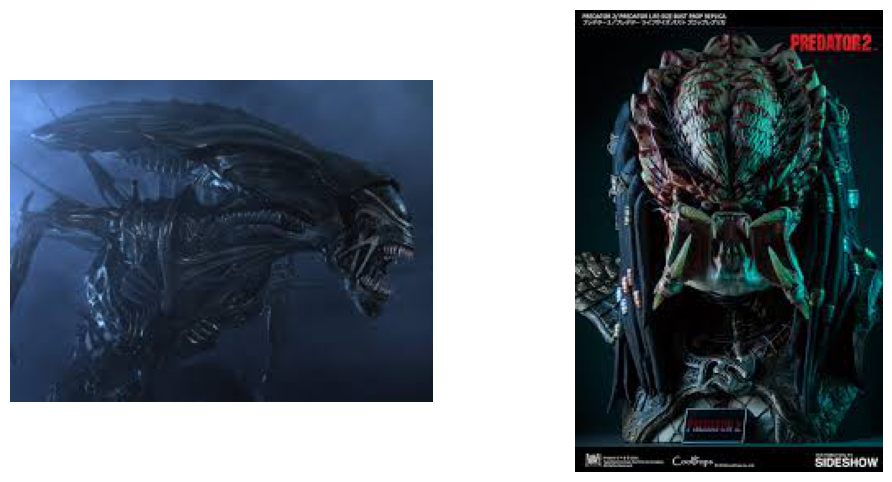

In [34]:
img1 = Image.open('data/validation/alien/21.jpg')
img2 = Image.open('data/validation/predator/17.jpg')

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img1)
axes[0].axis('off')
axes[1].imshow(img2)
axes[1].axis('off')
plt.show()

In [35]:
img1_input = data_transforms['validation'](img1)
img2_input = data_transforms['validation'](img2)
print(img1_input.shape)
print(img2_input.shape)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [36]:
test_batch = torch.stack([img1_input, img2_input])      # Image 2개가 Batch로 묶임
test_batch = test_batch.to(device)
test_batch.shape

torch.Size([2, 3, 224, 224])

In [38]:
y_pred = model(test_batch)
y_pred

tensor([[0.0260],
        [0.9311]], device='cuda:0', grad_fn=<SigmoidBackward0>)

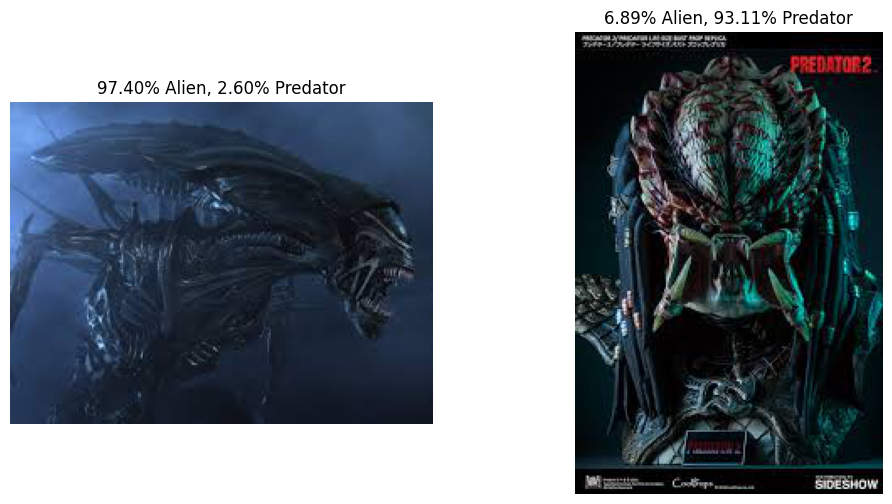

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].set_title(f'{(1-y_pred[0,0])*100:.2f}% Alien, {y_pred[0,0]*100:.2f}% Predator')
axes[0].imshow(img1)
axes[0].axis('off')

axes[1].set_title(f'{(1-y_pred[1,0])*100:.2f}% Alien, {y_pred[1,0]*100:.2f}% Predator')
axes[1].imshow(img2)
axes[1].axis('off')
plt.show()

### 과제
  * 전이학습으로 "강아지와 고양이" 구분하기
  * https://www.kaggle.com/datasets/samuelcortinhas/cats-and-dogs-image-classification